## Regression Modeling

This notebook shows the relationship between both country and company level information with company scope 1&2 and scope 3 emissions. The notbook is structured as follow:
1. Section 1: library and dataset preparation
2. Section 2: multiple linear regression on scope 1 and scope 2 emissions
3. Section 3: multiple linear regression on scope 3 emissions
4. Conclusion

## Section 1  - Import and dataframe preparation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, LassoCV

In [3]:
df = pd.read_csv('../data/output/msci_company_country.csv')
predictor_scope12 = pd.read_csv('../data/output/predictor_scope12.csv')
predictor_scope3 = pd.read_csv('../data/output/predictor_scope3.csv')

In [4]:
len(df['fsym_id'].unique()), df.shape

(2496, (46776, 36))

In [5]:
#checking the column
df.columns

Index(['t_date', 'fsym_id', 'gics_sector_name', 'gics_sub_industry_name',
       'port_weight', 'returns', 'region', 'company_cap', 'country_economy',
       'scope_1_tonnes', 'scope_2_tonnes', 'scope_3_tonnes',
       'net_zero_committed', 'target_status_class_year', 'emissions_lucf',
       'emissions_factor(kg/kwh)', 'emissions_gdp(kg/$ppp)',
       'emissions_in_trade', 'co2_oil', 'co2_cement', 'co2_coal', 'co2_gas',
       'agriculture', 'land_use_forestry', 'waste', 'industry',
       'manufact_construction', 'transport', 'electr_heat', 'buildings',
       'fugitive_emission', 'other_fuel_combustion', 'aviation_shipping',
       'Entity', 'all_emission', 'scope1_2_emission'],
      dtype='object')

In [6]:
df.drop(columns=['scope_1_tonnes','scope_2_tonnes', 'all_emission' ], inplace=True) 

In [7]:
#dummifying the categorical column
df_dummy  = pd.get_dummies(df, columns=['gics_sector_name', 'gics_sub_industry_name', 'region',  'company_cap', 
                             'country_economy',  'Entity', 'net_zero_committed', 'target_status_class_year'])

In [8]:
#now I can drop these last two columns for modeling
df_dummy.drop(columns=['t_date', 'fsym_id'], inplace=True)

## Section 2 - Predicting Scope 1 & Scope 2 Emissions

**Step 1** Assembling Predictors

In [9]:
#accessing my predictors
features1 = [col for col in predictor_scope12.set_index('Unnamed: 0').T]

In [10]:
X = df_dummy[features1]
y = df_dummy['scope1_2_emission']

**Step 2** Instantiating Linear Regression Model and train test split the df

In [11]:
lr1 = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**Step 3** Transforming target

In [12]:
# y_train = np.log(y_train)
# y_test = np.log(y_test)

<AxesSubplot:>

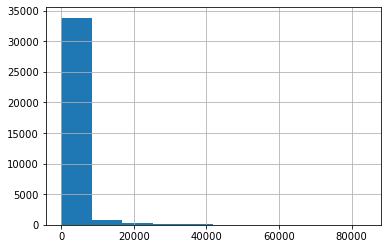

In [13]:
y_train.hist()

**Step 4** Fitting and Scoring the Linear regression model

In [14]:
#Fitting the model
lr1.fit(X_train, y_train)

LinearRegression()

In [15]:
#R2 for train
train_score = lr1.score(X_train, y_train)
print(train_score)
#R2 for test
test_score = lr1.score(X_test, y_test)
print(test_score)
#R2 for multiple test
print(cross_val_score(lr1, X_train, y_train).mean())

0.6764143711028605
0.7093906739608525
0.6716423073833373


**Step 5** Predicting Emission and Evaluating The model

In [16]:
prediction = lr1.predict(X)
#prediction = np.exp(prediction)

In [17]:
#trasnforming in log also the observed emission
df_dummy['scope1_2_emission_predicted'] = prediction
#df_dummy['scope1_2_emission'] = np.log(df_dummy['scope1_2_emission'])

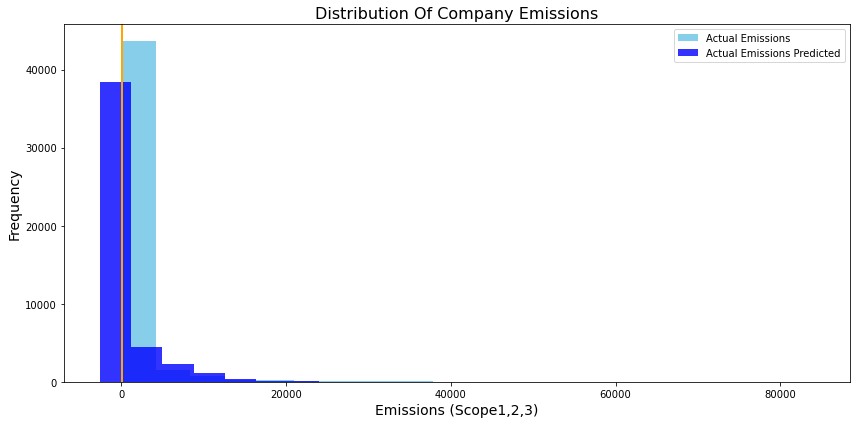

In [18]:
#looking at distribution of what I predicted against original
# plotting the distribution of my target
plt.figure(figsize = (12, 6))
plt.hist(df_dummy['scope1_2_emission'], color = 'skyblue',label = 'Actual Emissions', bins=20)
plt.hist(df_dummy['scope1_2_emission_predicted'], color = 'b', 
           label = 'Actual Emissions Predicted', alpha = 0.8, bins=20)
plt.axvline(df_dummy['scope1_2_emission'].median(), color = 'orange', lw=2)
plt.xlabel('Emissions (Scope1,2,3)', fontdict= {'fontsize':14})
plt.ylabel('Frequency', fontdict= {'fontsize':14})
plt.title('Distribution Of Company Emissions', fontdict = {'fontsize':16})

plt.legend()
plt.tight_layout()

In [19]:
#evaluating the mean squared error against th evariance of original data: if it is minor is better
metrics.mean_squared_error(df_dummy['scope1_2_emission'], df_dummy['scope1_2_emission_predicted']) < df_dummy['scope1_2_emission'].var()

True

In [20]:
residual = df_dummy['scope1_2_emission'] - df_dummy['scope1_2_emission_predicted']

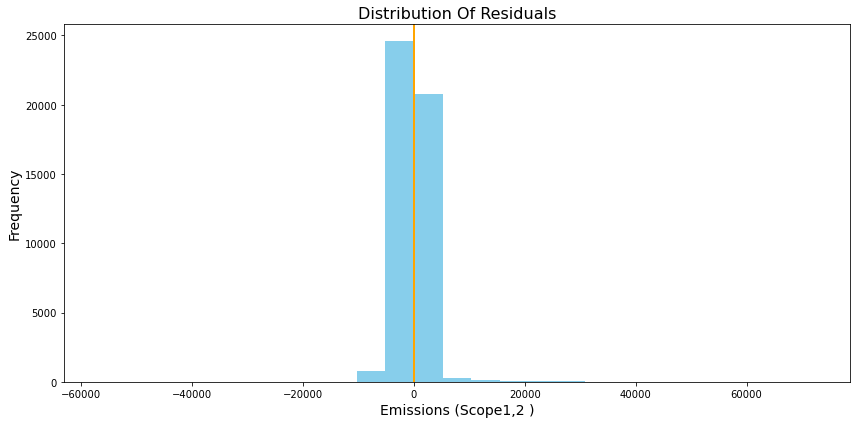

In [21]:
plt.figure(figsize = (12, 6))
plt.hist(residual, color = 'skyblue', bins=25)
plt.axvline(residual.mean(), color = 'orange', lw=2)
plt.xlabel('Emissions (Scope1,2 )', fontdict= {'fontsize':14})
plt.title('Distribution Of Residuals', fontdict = {'fontsize':16})
plt.ylabel('Frequency', fontdict= {'fontsize':14})
plt.tight_layout();

/Users/filoradice/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


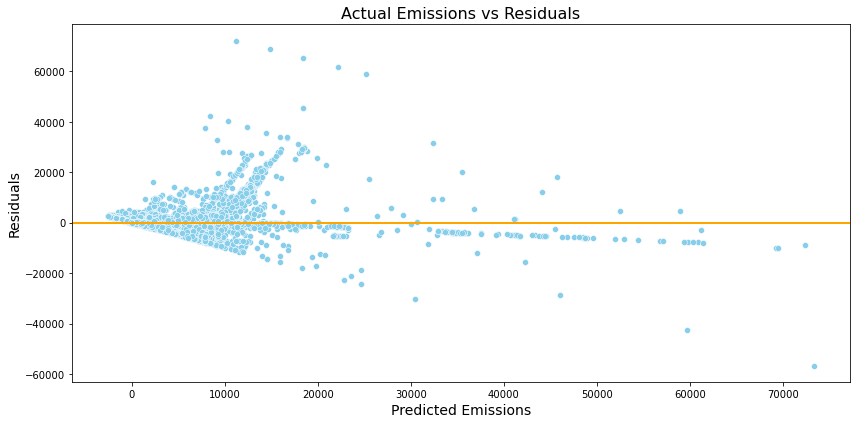

In [22]:
plt.figure(figsize = (12, 6))
plt.axhline(residual.mean(), color = 'orange', lw=2)
sns.scatterplot(df_dummy['scope1_2_emission_predicted'], residual, color = 'skyblue')
plt.xlabel('Predicted Emissions', fontdict= {'fontsize':14})
plt.ylabel('Residuals', fontdict= {'fontsize':14})
plt.title('Actual Emissions vs Residuals', fontdict = {'fontsize':16})
plt.tight_layout();

In [23]:
scope12_coeff = pd.DataFrame(lr1.coef_, index=features1, columns=['coeff']).sort_values(by='coeff', ascending=False)
scope12_bestpred = scope12_coeff[(scope12_coeff['coeff']>0.2) | (scope12_coeff['coeff']<-2)]

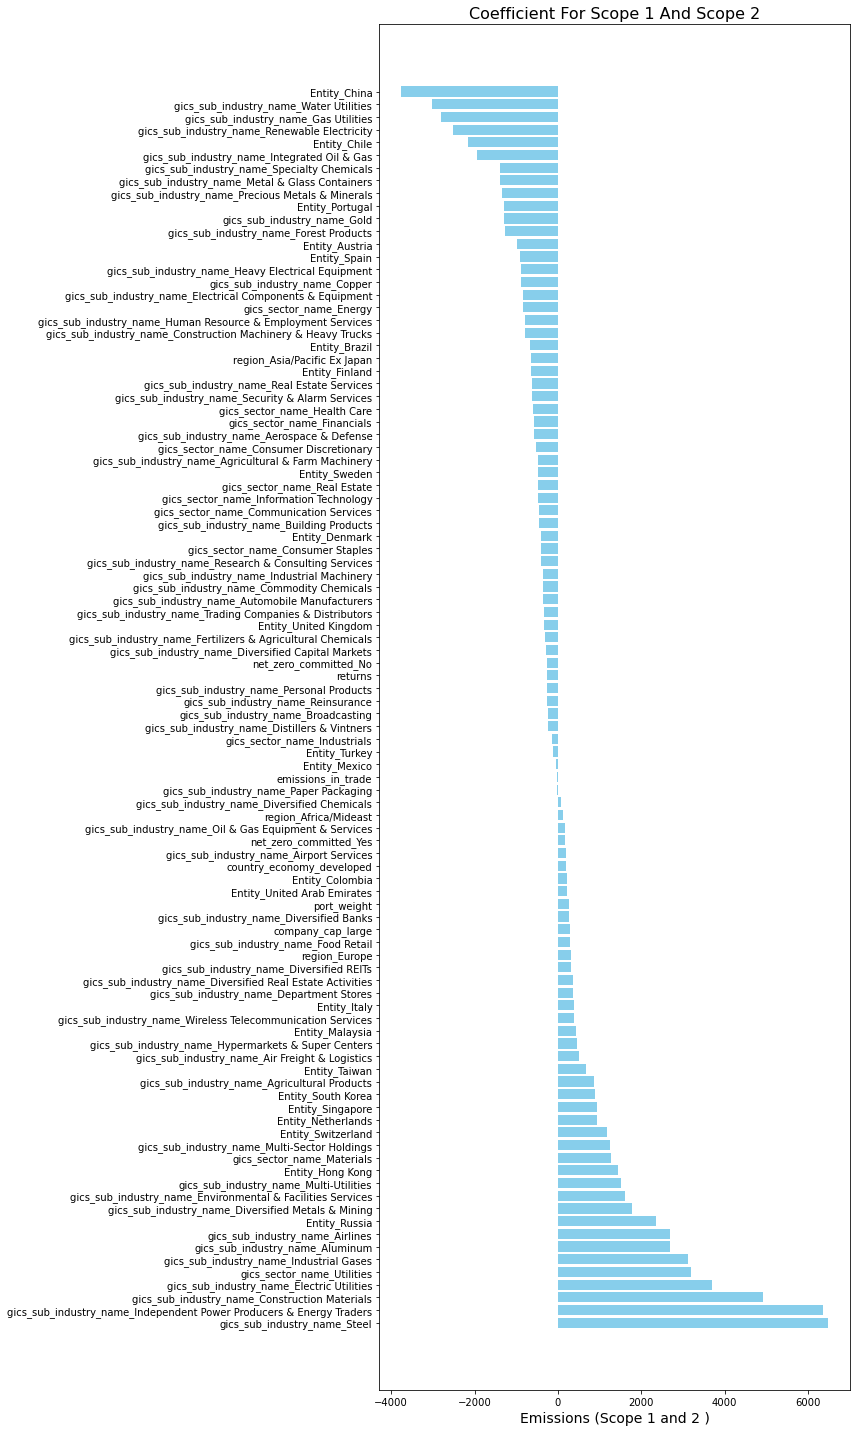

In [24]:
plt.figure(figsize = (12, 20))
plt.barh(scope12_bestpred.index,scope12_bestpred['coeff'], color = 'skyblue')
#plt.axvline(residual.mean(), color = 'orange', lw=2)
plt.xlabel('Emissions (Scope 1 and 2 )', fontdict= {'fontsize':14})
plt.title('Coefficient For Scope 1 And Scope 2', fontdict = {'fontsize':16})
plt.tight_layout();

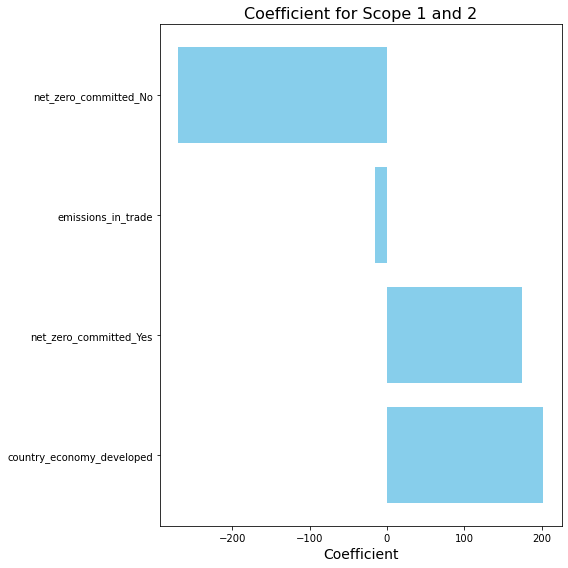

In [25]:
predictors_of_interest1 = scope12_coeff[~(scope12_coeff.index.str.contains('gics')) 
                                               & (~scope12_coeff.index.str.contains('region')) 
                                               & (~scope12_coeff.index.str.contains('Entity'))
                                              & (~scope12_coeff.index.str.contains('weight'))
                                        & (~scope12_coeff.index.str.contains('returns'))
                                        & (~scope12_coeff.index.str.contains('large'))
                                       & ((scope12_coeff['coeff']>= 4) | (scope12_coeff['coeff']<= -1))]
plt.figure(figsize = (8, 8))
plt.barh(predictors_of_interest1.index,predictors_of_interest1['coeff'], color = 'skyblue')
#plt.axvline(residual.mean(), color = 'orange', lw=2)
plt.xlabel('Coefficient', fontdict= {'fontsize':14})
plt.title('Coefficient for Scope 1 and 2', fontdict = {'fontsize':16})
plt.tight_layout()
plt.savefig('../images/scope12_coefficient.png')

In [26]:
predictors_of_interest1

,coeff
country_economy_developed,202.285835
net_zero_committed_Yes,174.960675
emissions_in_trade,-15.986954
net_zero_committed_No,-269.747985


## Section 3 - Predicting Scope 3 Emissions

**Step 1** Assembling Predictors

In [27]:
df_dummy.drop(columns='scope1_2_emission_predicted', inplace=True)

In [28]:
#accessing my predictors
feature2 = [col for col in predictor_scope3.set_index('Unnamed: 0').T if col!='scope_3_tonnes']

In [29]:
X = df_dummy[feature2 ]
y = df_dummy['scope_3_tonnes']

**Step 2** Instantiating Linear Regression Model and train test split the df

In [30]:
lr2 = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**Step 3** Scaling predictors and transforming target

In [31]:
# y_train = np.log(y_train)
# y_test = np.log(y_test)

**Step 4** Fitting and Scoring the Linear regression model

In [32]:
#Fitting the model
lr2.fit(X_train, y_train)

LinearRegression()

In [33]:
#R2 for train
train_score = lr2.score(X_train, y_train)
print(train_score)
#R2 for test
test_score = lr2.score(X_test, y_test)
print(test_score)
#R2 for multiple test
print(cross_val_score(lr2, X_train, y_train).mean())

0.705359441374108
0.7354597401006272
0.7000353762592916


**Step 5** Predicting Emission and Evaluating The model

In [34]:
prediction = lr2.predict(X)
#prediction = np.exp(prediction)

In [35]:
#trasnforming in log also the observed emission for comparison
df_dummy['scope_3_tonnes_predicted'] = prediction
#df_dummy['scope_3_tonnes'] = np.log(df_dummy['scope_3_tonnes'])

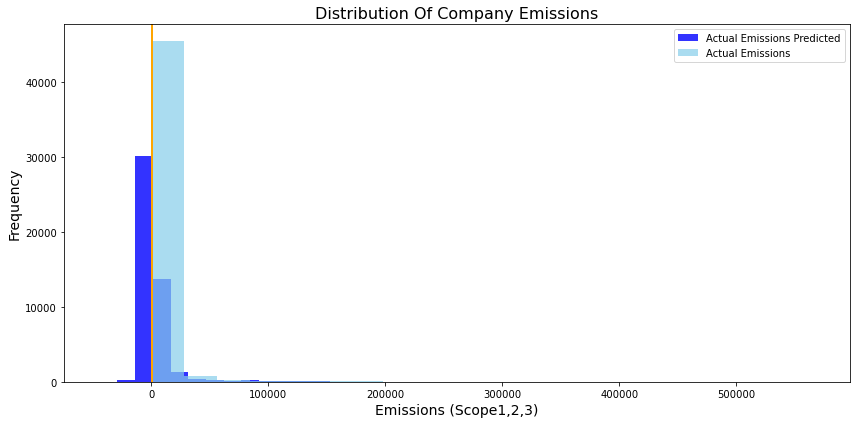

In [36]:
#looking at distribution of what I predicted against original
# plotting the distribution of my target
plt.figure(figsize = (12, 6))
plt.hist(df_dummy['scope_3_tonnes_predicted'], color = 'b', 
           label = 'Actual Emissions Predicted', alpha = 0.8, bins=20)
plt.hist(df_dummy['scope_3_tonnes'], color = 'skyblue',label = 'Actual Emissions', bins=20, alpha = 0.7)

plt.axvline(df_dummy['scope_3_tonnes_predicted'].median(), color = 'orange', lw=2)
plt.xlabel('Emissions (Scope1,2,3)', fontdict= {'fontsize':14})
plt.ylabel('Frequency', fontdict= {'fontsize':14})
plt.title('Distribution Of Company Emissions', fontdict = {'fontsize':16})
plt.legend()
plt.tight_layout()

In [37]:
#evaluating the mean squared error against th evariance of original data: if it is minor is better
metrics.mean_squared_error(df_dummy['scope_3_tonnes'], df_dummy['scope_3_tonnes_predicted']) < df_dummy['scope_3_tonnes'].var()

True

In [38]:
residual = df_dummy['scope_3_tonnes'] - df_dummy['scope_3_tonnes_predicted']

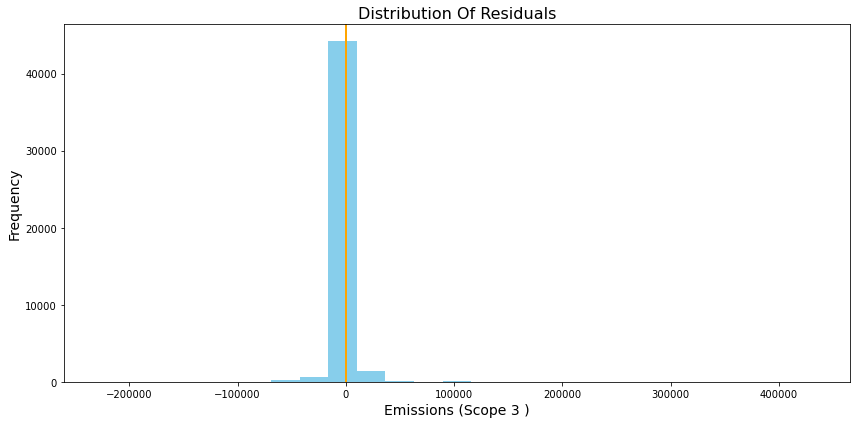

In [39]:
plt.figure(figsize = (12, 6))
plt.hist(residual, color = 'skyblue', bins=25)
plt.axvline(residual.mean(), color = 'orange', lw=2)
plt.xlabel('Emissions (Scope 3 )', fontdict= {'fontsize':14})
plt.title('Distribution Of Residuals', fontdict = {'fontsize':16})
plt.ylabel('Frequency', fontdict= {'fontsize':14})
plt.tight_layout();

/Users/filoradice/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


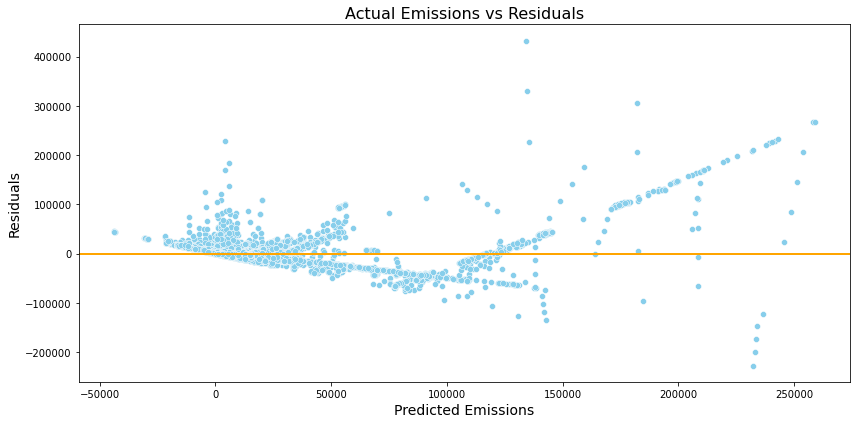

In [40]:
plt.figure(figsize = (12, 6))
plt.axhline(residual.mean(), color = 'orange', lw=2)
sns.scatterplot(df_dummy['scope_3_tonnes_predicted'], residual, color = 'skyblue')
plt.xlabel('Predicted Emissions', fontdict= {'fontsize':14})
plt.ylabel('Residuals', fontdict= {'fontsize':14})
plt.title('Actual Emissions vs Residuals', fontdict = {'fontsize':16})
plt.tight_layout();

In [41]:
scope3_coeff = pd.DataFrame(lr2.coef_, index=feature2, columns=['coeff']).sort_values(by='coeff', ascending=False)
scope3_bestpred = scope3_coeff[(scope3_coeff['coeff']>2) | (scope3_coeff['coeff']<-1)]


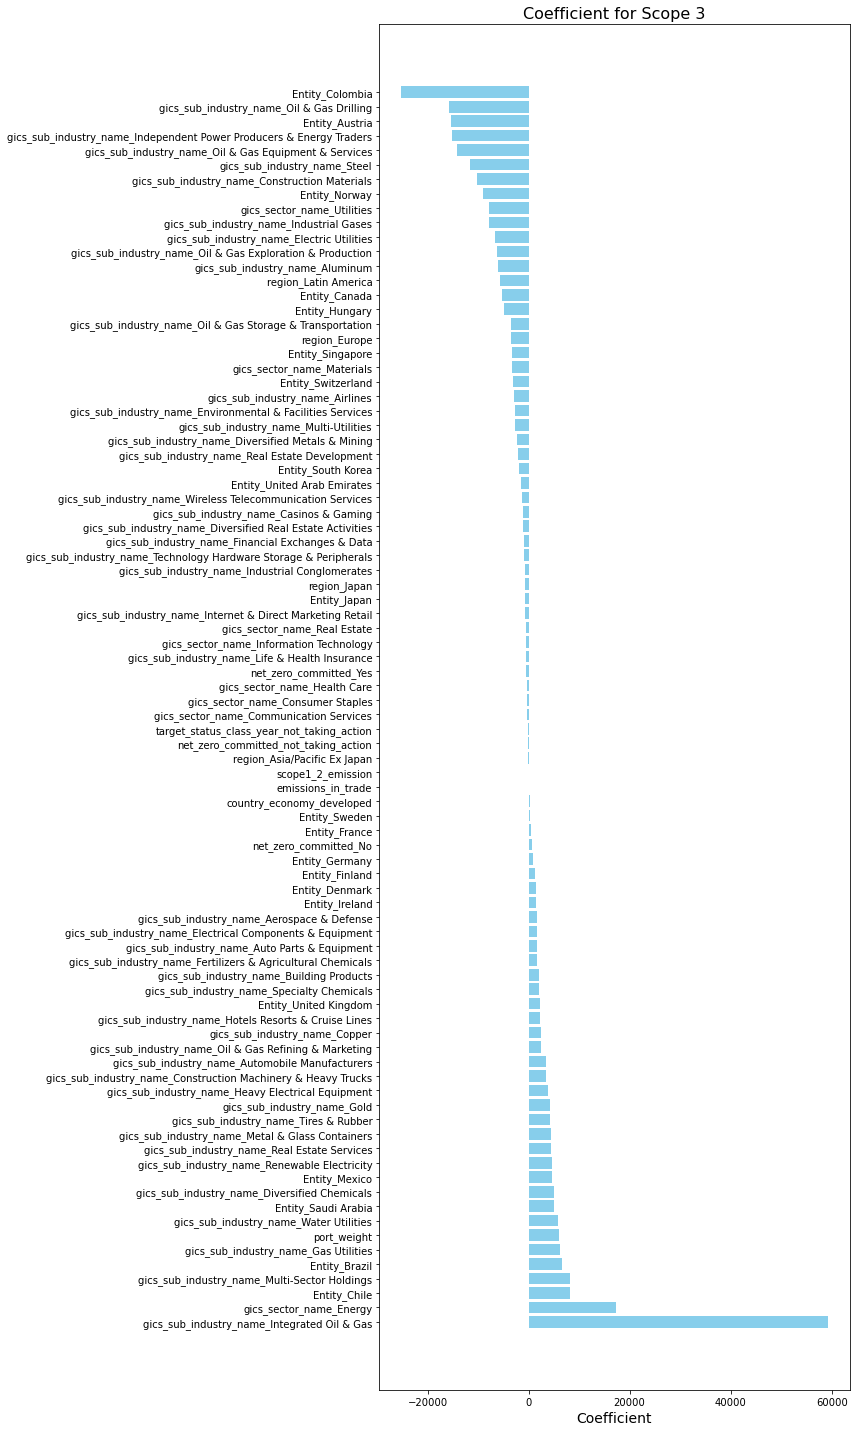

In [42]:
plt.figure(figsize = (12, 20))
plt.barh(scope3_bestpred.index,scope3_bestpred['coeff'], color = 'skyblue')
#plt.axvline(residual.mean(), color = 'orange', lw=2)
plt.xlabel('Coefficient', fontdict= {'fontsize':14})
plt.title('Coefficient for Scope 3', fontdict = {'fontsize':16})
plt.tight_layout();

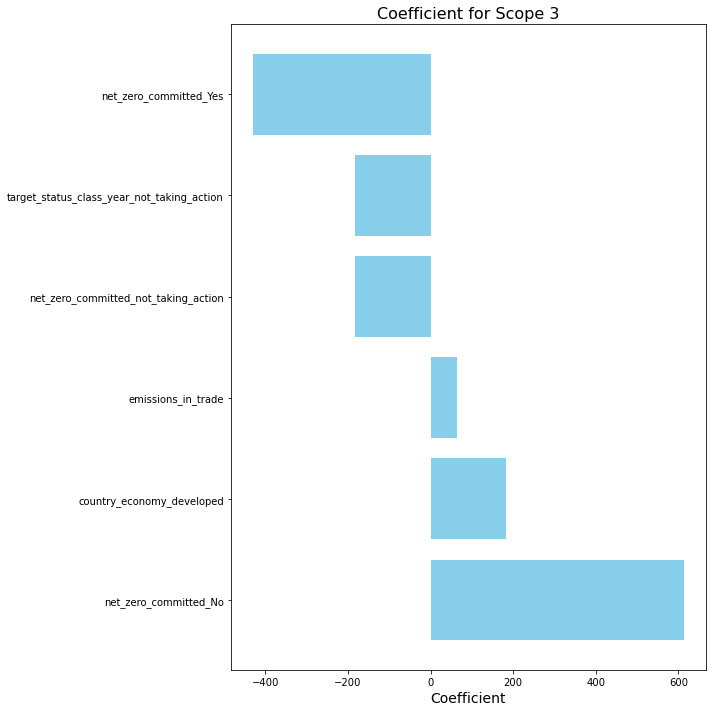

In [43]:
predictors_of_interest2 = scope3_coeff[~(scope3_coeff.index.str.contains('gics')) 
                                             & (~scope3_coeff.index.str.contains('region')) 
                                             & (~scope3_coeff.index.str.contains('Entity'))
                                            & (~scope3_coeff.index.str.contains('weight'))
                                      & ((scope3_coeff['coeff']>= 4) | (scope3_coeff['coeff']<= -1))] #removing coefficient ~=0.00001
plt.figure(figsize = (10, 10))
plt.barh(predictors_of_interest2.index,predictors_of_interest2['coeff'], color = 'skyblue')
#plt.axvline(residual.mean(), color = 'orange', lw=2)
plt.xlabel('Coefficient', fontdict= {'fontsize':14})
plt.title('Coefficient for Scope 3', fontdict = {'fontsize':16})
plt.tight_layout()
plt.savefig('../images/scope3_coefficient.png')


In [44]:
predictors_of_interest2

,coeff
net_zero_committed_No,613.450781
country_economy_developed,183.479648
emissions_in_trade,63.656397
net_zero_committed_not_taking_action,-182.224726
target_status_class_year_not_taking_action,-182.224726
net_zero_committed_Yes,-431.226056


## Conclusion

companies climate target, country economy and emissions in trade seem to have a significant relationship with both scope 1 and 2 and scope 3 carbon emissions. The coefficient value of each predictor shows how much company emissions (in thousand of tonnes) would increase (for positive values) or decrease (for negative values), if we would hold everything else constant. It is interesting to notice the difffernece in directionality of netzero commitment for scope1,2 emissions and scope 3 emissions. For instance, holding everything else constant, a company that did not commit to netzero tends to emit ~600ktonnes of scope 3 emissions more than a company that did commit to netzero. Viceversa, a company that did commit to netzero tends to emit  ~175kt  of scope 1, 2 emissions than companies that did not commit to Netzero. This relationship seems to suggest that companies that have higher level of scope 3 emissions and lower level of scope 1,2 emissions are less likely to commit to netzero. The rational behind this conclusion is explained with the classification model that aims to firther explore the relationship between company emissions and netzero commitments.  

In [45]:
#Scope 1 and 2 Emissions
predictors_of_interest1

,coeff
country_economy_developed,202.285835
net_zero_committed_Yes,174.960675
emissions_in_trade,-15.986954
net_zero_committed_No,-269.747985


In [46]:
#Scope 3 Emissions
predictors_of_interest2

,coeff
net_zero_committed_No,613.450781
country_economy_developed,183.479648
emissions_in_trade,63.656397
net_zero_committed_not_taking_action,-182.224726
target_status_class_year_not_taking_action,-182.224726
net_zero_committed_Yes,-431.226056
